<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_AutoDiff_UserCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import scipy as sc
from scipy import special

import jax
import jax.numpy as jnp
import jax.scipy as jsc                    # <--------------

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18


# Theme: auto-differentiation applied to algorithms
Example of the recursive algorithm for extracting the square root of a number

## Simple Numpy code

In [3]:
def sqrt_rec(x):
    val = x
    for i in range(0,10):
        val = (val+x/val)/2.
    return val


## JAX version that's just as simple: jax.lax.fori_loop

In [5]:
@jit # compilation decorator
def jax_sqrt_rec(x):

    # struture: val = body(i,val)
    def body(i,val):
        return (val+x/val)/2.

    # struture: val =  loop(i_start, i_end, function, initialisation)
    return jax.lax.fori_loop(0,10,body,x)


- By default `jax.lax.fori_loop` compile the `body` function
- The loop bounds must be static (we will come back to that constraint later)

## We apply the gradient that we vectorize

In [6]:
vgradsqrt = vmap(grad(jax_sqrt_rec))

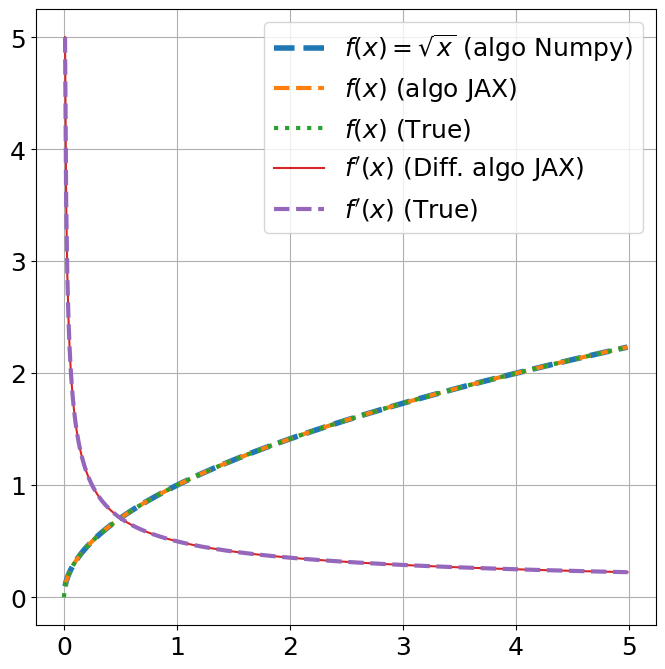

In [11]:
plt.figure(figsize=(8,8))
x = jnp.arange(0,5,0.01)
plt.plot(x, sqrt_rec(x), label=r"$f(x)=\sqrt{x}$ (algo Numpy)", ls="--",lw=4)
plt.plot(x, jax_sqrt_rec(x), lw=3,ls='--', label=r"$f(x)$ (algo JAX)")
plt.plot(x, jnp.sqrt(x), lw=3,ls=':', label=r"$f(x)$ (True)")

plt.plot(x, vgradsqrt(x), label=r"$f^\prime(x)$ (Diff. algo JAX)")

#plt.plot(x, vmap(grad(root))(x), label=r"$f^\prime(x)$ (Diff. algo Numpy)")  # Tout a fait possible mais moins Jax-idiom
plt.plot(x, 1/(2*jnp.sqrt(x)), lw=3,ls='--',label=r"$f^\prime(x)$ (True)")
plt.legend()
plt.grid();

In [12]:
# If you're curious: jax.make_jaxpr(jax_sqrt_rec)(1.)

# Simpson integration code (composite)
$$
\begin{align}
\int_a^b f(x)dx &\approx \frac{b-a}{3n}\sum_{j=1}^{n/2}\left[ f(x_{2j-2} + 4 f(x_{2j-1}) + f(x_{2j}))\right] \\
&= \frac{b-a}{6n} \left[f(x_0)+ 4 \sum_{j=1}^{n/2}f(x_{2j-1}) + 2 \sum_{j=1}^{n/2-1} f(x_{2j}) +f(x_n) \right]
\end{align}
$$

In [15]:
# Numpy version
def simps(f, a, b, N):
    assert N%2==0, f"use N even but get {N}"
    dx = (b - a) / N
    x = np.linspace(a, b, N + 1)
    y = f(x)
    w = np.ones_like(y)
    w[2:-1:2] = 2.
    w[1::2]   = 4.
    S = dx / 3. * np.einsum("i...,i...",w,y)
    return S


In [61]:
#JAX version
#@jit   # a simple JIT will crash  both due to 'f' and 'N'
@partial(jit, static_argnums=(0,3))  # this JIT is ok
def jax_simps(f, a,b, N=512):
    assert N%2==0, f"use N even but get {N}"
    # N must be even
    dx = (b - a) / N
    x = jnp.linspace(a, b, N + 1)     # here N must be static
    y = f(x)                          # here f must be static
    w = jnp.ones_like(y)
    w = w.at[2:-1:2].set(2.)     # remind: w is immutable
    w = w.at[1::2].set(4.)
    S = dx / 3. * jnp.einsum('i...,i...',w,y)
    return S


In [43]:
def func(x):
    return x**(1/10) * jnp.exp(-x)

## simple use case

In [44]:
a = 0.
b = a+0.5

In [51]:
print(simps(func, a, b, N=2**10), jax_simps(func, a, b, N=100))

0.32963201204750436 0.3289307480267466


In [52]:
print(simps(func, a, b, N=2**10), jax_simps(func, a, b, N=2**10)) #slow convergence

0.32963201204750436 0.32963201204750436


In [54]:
# the truth
print(jsc.special.gamma(1.+1./10)*(1.-jsc.special.gammaincc(1.+1./10,0.5)))

0.32969082576166414


nb. jax.scipy implements a number of Scipy functions, but not all of them

## Function family with a series of integration intervals [a,a+1/2] a:0,0.1,0.2...

In [56]:
@jit
def jax_funcN(x):
    return jnp.stack([x**(i/10) * jnp.exp(-x) for i in range(50)],axis=1)

In [58]:
ja = jnp.arange(0,20,0.1)
jb = ja+0.5

In [59]:
res = jax_simps(jax_funcN,ja,jb,  N=2**10)

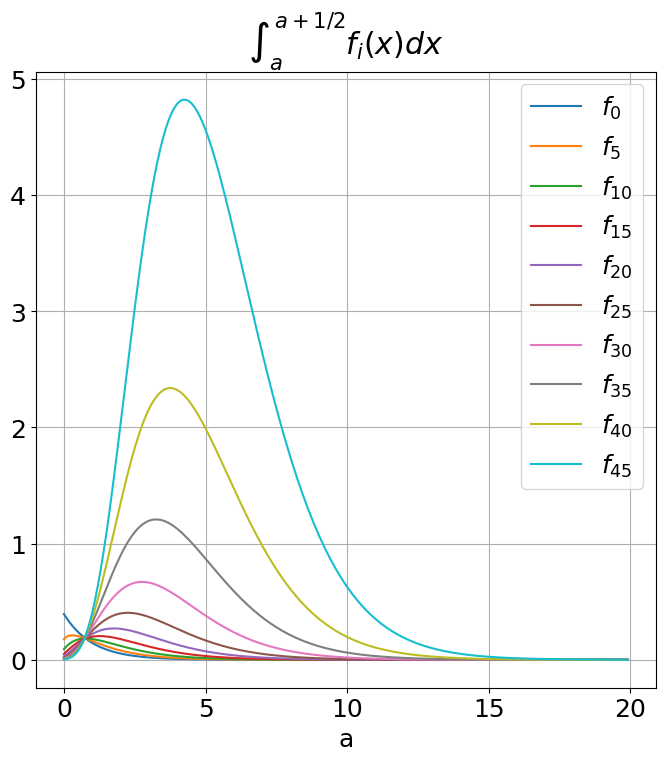

In [60]:
plt.figure(figsize=(8,8))
for i in range(0,50,5):
    plt.plot(ja,res[i,:],label=rf"$f_{{{i}}}$")
plt.xlabel("a")
plt.title(r"$\int_{a}^{a+1/2} f_i(x) dx$")
plt.grid()
plt.legend();

# Check that the gradient of the integration is equal to the function itself
$$
\frac{d}{dx} \int_a^x f(z) dz = f(x)
$$

In [67]:
f5 = lambda x: x**2 * jnp.exp(-x)

In [68]:
a=0
intf5 = lambda x: jax_simps(f5,a,x,N=2**10)

In [69]:
vintf5 = vmap(intf5)

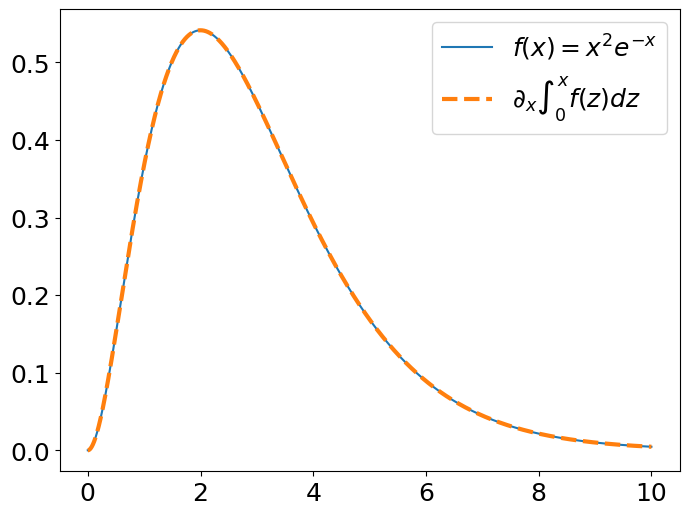

In [71]:
plt.figure(figsize=(8,6))
x = jnp.arange(0,10,0.001)
plt.plot(x,f5(x),label=r"$f(x)=x^2 e^{-x}$")
plt.plot(x,vmap(grad(intf5))(x), ls="--", lw=3, label="$\partial_x \int_0^x f(z)dz$")
plt.legend();

# A more efficient method of integration: Clenshaw Curtis quadrature

In [72]:
from typing import NamedTuple, Tuple

from jax import Array, jit, lax, vmap

# move pure function out of the class
def abs_weights(n: int):
  #assert n > 1
  points = -jnp.cos(jnp.linspace(0, jnp.pi, n))

  if n == 2:
    weights = jnp.array([1.0, 1.0])
    return points, weights

  n -= 1
  N = jnp.arange(1, n, 2)
  length = len(N)
  m = n - length
  v0 = jnp.concatenate([2.0 / N / (N - 2), jnp.array([1.0 / N[-1]]), jnp.zeros(m)])
  v2 = -v0[:-1] - v0[:0:-1]
  g0 = -jnp.ones(n)
  g0 = g0.at[length].add(n)
  g0 = g0.at[m].add(n)
  g = g0 / (n**2 - 1 + (n % 2))

  w = jnp.fft.ihfft(v2 + g)
  # assert max(w.imag) < 1.0e-15
  w = w.real

  if n % 2 == 1:
    weights = jnp.concatenate([w, w[::-1]])
  else:
    weights = jnp.concatenate([w, w[len(w) - 2::-1]])

  return points, weights

class ClenshawCurtisQuad(NamedTuple):  # NamedTuple is already a pytree
  order: int
  absc: Array
  absw: Array
  errw: Array

  @classmethod  # alternative constructor, doesn't get in the way of flatten/unflatten
  def init(cls, order: int):
    order = 2 * order + 1
    absc, absw, errw = cls.compute_weights(order)
    absc, absw = cls.rescale_weights(absc, absw)
    return cls(order=order, absc=absc, absw=absw, errw=errw)

  @staticmethod  # staticmethod to ensure purity
  def compute_weights(order: int):
    x, wx = abs_weights(order)
    nsub = (order + 1) // 2
    _, wsub = abs_weights(nsub)
    errw = wx.at[::2].add(-wsub)
    return x, wx, errw

  @staticmethod
  def rescale_weights(
    absc: Array,
    absw: Array,
    *,
    interval_in: Tuple[float, float] = (-1, 1),
    interval_out: Tuple[float, float] = (0, 1),
  ):
    (in_min, in_max), (out_min, out_max) = interval_in, interval_out
    delta_in, delta_out = in_max - in_min, out_max - out_min
    absc = ((absc - in_min) * out_max - (absc - in_max) * out_min) / delta_in
    absw = delta_out / delta_in * absw
    return absc, absw

@partial(jit, static_argnums=(0,))   # quad is a Pytree => do not need to make it static
def quad_integral(f, a, b, quad: ClenshawCurtisQuad):
  a = jnp.atleast_1d(a)
  b = jnp.atleast_1d(b)
  d = b - a
  xi = a[jnp.newaxis, :] + jnp.einsum('i...,k...->ik...', quad.absc, d)
  xi = xi.squeeze()
  fi = f(xi)
  S = d * jnp.einsum('i...,i...', quad.absw, fi)
  return S.squeeze()

## a little benchmarking: 1) warm-up for compilation, 2) block_until_ready()

Reuse the example of the function familly and the set of integration bounds [a,a+1/2] a:0,0.1,0.2...

In [86]:
res_sim = jax_simps(jax_funcN,ja,jb,N=2**15)     # we must push N very high (CPU: 45sec)

In [89]:
quad = ClenshawCurtisQuad.init(150)              # 300 pts or so
res_cc=quad_integral(jax_funcN,ja,jb,quad)       # quite instantaneous

In [90]:
np.allclose(res_cc,res_sim,rtol=0.,atol=1e-6)

True

In [ ]:
# Too long .....%timeit  res_sim = jax_simps(jax_funcN,ja,jb,N=2**15).block_until_ready()

In [91]:
#warmup we need it if we want to see the XLA compilation time
%time _=quad_integral(jax_funcN,jnp.array([0]),jnp.array([1]),quad).block_until_ready()


CPU times: user 2.78 ms, sys: 0 ns, total: 2.78 ms
Wall time: 2.68 ms


In [92]:
%timeit quad_integral(jax_funcN,ja,jb,quad).block_until_ready()

63.4 ms ± 689 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Incremental integration : use of jax.lax.scan

Python code equivalent
```python
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

In [94]:
def incremental_int(fn,t, order=10):
    """Incremetal intergration using Clenshaw Curtis Quadrature

       Example::
           >>> f = lambda x: jnp.sqrt(x) * jnp.exp(-x) * jnp.sin(100.*x)
           >>> tinc = jnp.linspace(0.,1.,4096)
           >>> incremental_int(f5,tinc,150)

       It uses CC quad to compute int_t[i]^t[i+1] fn(x) dx

       Inputs:
           fn : function (vectorized of 1 variable)
           t : array
           order : order of the Clenshaw Curtis Quadrature
       Outputs:
           array of int_t[0]^t[i] fn(x) dx  i=0, len(t)-1

    """
    quad = ClenshawCurtisQuad.init(order)
    def integ(carry,t):
        y, t_prev = carry
        y = y + quad_integral(fn,t_prev,t,quad)
        return (y,t),y
    (yf, _), y = jax.lax.scan(integ, (0., jnp.array(t[0])), t)
    return y

In [103]:
f5 = lambda x: jnp.sqrt(x) * jnp.exp(-x)

In [104]:
quad=ClenshawCurtisQuad.init(150)
tdef = jnp.linspace(0,10,5000)
res_cc_def = quad_integral(f5,0.0,tdef,quad)


In [105]:
tinc = jnp.linspace(0,10,5000)
res_cc_inc = incremental_int(f5,tinc)  # note order=10 by default << 150

In [106]:
true_intf5 = lambda t: jnp.exp(jsc.special.gammaln(1.5))\
        *(1.-jsc.special.gammaincc(1.5,t))

In [107]:
t_val=jnp.linspace(0,10,5000)

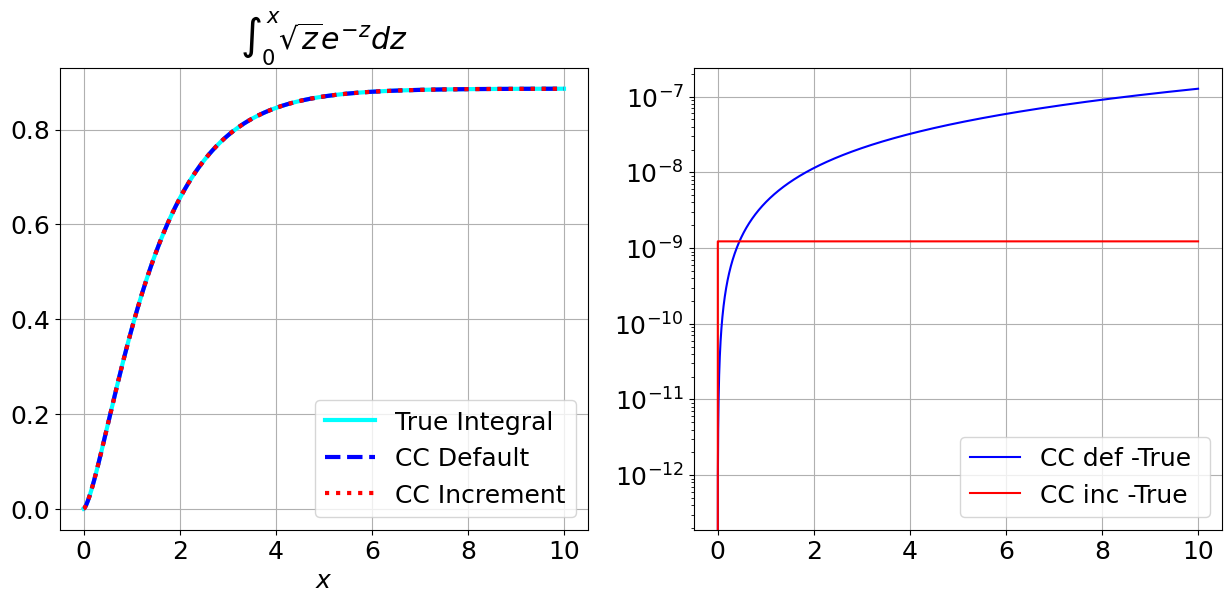

In [112]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(t_val, vmap(true_intf5)(t_val), label="True Integral",lw=3,c='cyan')
ax[0].plot(t_val, jnp.interp(t_val,tdef,res_cc_def),lw=3,ls="--", label="CC Default",c='blue')
ax[0].plot(t_val, jnp.interp(t_val,tinc,res_cc_inc),lw=3,ls=":", label="CC Increment",c='red')
ax[0].set_xlabel(r"$x$")
ax[0].legend()
ax[0].grid()
ax[0].set_title(r"$\int_0^x \sqrt{z} e^{-z} dz$");
#
ax[1].plot(t_val, jnp.abs(res_cc_def-vmap(true_intf5)(t_val)), label="CC def -True ",c='blue')
ax[1].plot(t_val, jnp.abs(res_cc_inc-vmap(true_intf5)(t_val)), label="CC inc -True ",c='red')
ax[1].set_yscale("log")
ax[1].legend()
ax[1].grid()


# A real use case: cosmological distance studies

We'll create a PyTree class, use switch and integration...

This comes from [JAX-Cosmo library](https://github.com/DifferentiableUniverseInitiative/jax_cosmo)
See also the paper [here](https://arxiv.org/abs/2302.05163)

In [120]:
from dataclasses import dataclass
from jax.tree_util import register_pytree_node_class

@dataclass(frozen=True)
class Constante:
    rh: float = 2997.92458  # h^{-1} Mpc
    H0: float = 100.0  # km/s/( h^{-1} Mpc)

const = Constante()


#The set of Python types that are considered internal PyTree nodes is extensible
@register_pytree_node_class
class Cosmology:
    def __init__(self, Omega_c, Omega_b, h, Omega_k, w0, wa):
        """
            Omega_c, float
              Cold dark matter density fraction.
            Omega_b, float
              Baryonic matter density fraction.
            h, float
              Hubble constant divided by 100 km/s/Mpc; unitless.
            Omega_k, float
              Curvature density fraction.
            w0, float
              First order term of dark energy equation
            wa, float
              Second order term of dark energy equation of state
        """
        # Store primary parameters
        self._Omega_c = Omega_c
        self._Omega_b = Omega_b
        self._h = h
        self._Omega_k = Omega_k
        self._w0 = w0
        self._wa = wa

        # Create a workspace where functions can store some precomputed
        # results
        self._workspace = {}

    def __str__(self):
        return (
              " h:"+ str(self.h)
            + " Omega_b:"+ str(self.Omega_b)
            + " Omega_c:"+ str(self.Omega_c)
            + " Omega_k:"+ str(self.Omega_k)
            + " w0:"+ str(self.w0)
            + " wa:"+ str(self.wa)
        )

    def __repr__(self):
        return self.__str__()

    # Operations for flattening/unflattening representation
    def tree_flatten(self):  # Flattens a pytree
        params = (
            self._Omega_c,
            self._Omega_b,
            self._h,
            self._Omega_k,
            self._w0,
            self._wa,
        )
        aux_data = None
        return (params, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):  # Reconstructs a pytree from the treedef and the leaves.
        # Retrieve base parameters
        Omega_c, Omega_b, h, Omega_k, w0, wa = children

        return cls(
            Omega_c=Omega_c,
            Omega_b=Omega_b,
            h=h,
            Omega_k=Omega_k,
            w0=w0,
            wa=wa,
        )

    # Cosmological parameters, base and derived
    @property
    def Omega(self):
        return 1.0 - self._Omega_k

    @property
    def Omega_b(self):
        return self._Omega_b

    @property
    def Omega_c(self):
        return self._Omega_c

    @property
    def Omega_m(self):
        return self._Omega_b + self._Omega_c

    @property
    def Omega_de(self):
        return self.Omega - self.Omega_m

    @property
    def Omega_k(self):
        return self._Omega_k

    @property
    def k(self):
        return -jnp.sign(self._Omega_k).astype(jnp.int8)

    @property
    def sqrtk(self):
        return jnp.sqrt(jnp.abs(self._Omega_k))

    @property
    def h(self):
        return self._h

    @property
    def w0(self):
        return self._w0

    @property
    def wa(self):
        return self._wa


an alternative to the decorator
```python
def flatten_func(obj):
  ...
def unflatten_func(aux_data, children):
  ...
jax.tree_util.register_pytree_node(Cosmology, flatten_func, unflatten_func)
```

Now envisage the following cosmological distances:`a`is the scale factor (redshift `z`  is such that $a=1/(1+z)$. So, $a=1$ is now, while $a=0$ is the beginning of the Universe (CMB is arround $z=1100$)...

$$
\begin{align}
(H(a)/H0)^2 &= E^2(a) = a^{-3}\Omega_m + a^{-2}\Omega_K +\Omega_\Lambda e^{f(a)} \\
f(a) &= -3(1+ω_0 + ω_a)\ln(a) + 3w_a(a-1)
\end{align}
$$
If $\omega_0=-1$ et $ω_a=0$ (this is the standard Lambda CDM) then  $f(a)=0$

$$
\chi(a) = R_H \int_a^1 \frac{da'}{a'^2E(a')}
$$

Transverse comoving distance (Notice we need a **switch**)
$$
f_k(a) = \begin{cases}
R_H \frac{1}{\sqrt{Ω_k}}\sinh(\sqrt{Ω_k}R_H \chi(a)) &  for\ Ω_k>0 \\
\chi(a) &for\ Ω_k=0 \\
R_H \frac{1}{\sqrt{Ω_k}}\sin(\sqrt{Ω_k}R_H \chi(a)) &  for\ Ω_k < 0
\end{cases}
$$
Angulaire and luminosity distances
$$
d_A(a) = a f_k(a), \qquad d_L(a) = f_k(a)/a
$$


In [121]:
atab = jnp.logspace(-3, 0.0, 10)
atabbis = jnp.log(atab)
atab

Array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ],      dtype=float64)

In [122]:
def z2a(z):
    """converts from redshift to scale factor"""
    return 1.0 / (1.0 + z)

def a2z(a):
    """converts from scale factor to  redshift"""
    return 1.0 / a - 1.0

def w(cosmo, a):
    """
    Linder 2003
     w(a) = w_0 + w_a (1 - a)
    """
    return cosmo.w0 + (1.0 - a) * cosmo.wa

def f_de(cosmo, a):
    """
        f(a) = -3 (1 + w_0 + w_a) \ln(a) + 3 w_a (a - 1)
    """
    return -3.0 * (1.0 + cosmo.w0 + cosmo.wa) * jnp.log(a) + 3.0 * cosmo.wa * (a - 1.0)

def Esqr(cosmo, a):
    """
      E^2(a) = \Omega_m a^{-3} + \Omega_k a^{-2} + \Omega_{de} e^{f(a)} =H(a)^2/H0^2
    """
    return (
        cosmo.Omega_m * jnp.power(a, -3)
        + cosmo.Omega_k * jnp.power(a, -2)
        + cosmo.Omega_de * jnp.exp(f_de(cosmo, a))
    )

def H(cosmo, a):
    """
    H(a) = H0 * E(a)
    """
    return const.H0 * jnp.sqrt(Esqr(cosmo, a))

def dchioverda(cosmo, a):
    """
    \frac{d \chi}{da}(a) = \frac{R_H}{a^2 E(a)}
    """
    return const.rh / (a**2 * jnp.sqrt(Esqr(cosmo, a)))

def radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256):
    """
    \chi(a) =  R_H \int_a^1 \frac{da^\prime}{{a^\prime}^2 E(a^\prime)}
    """
    # Check if distances have already been computed
    if not "background.radial_comoving_distance" in cosmo._workspace.keys():
        # Compute tabulated array
        atab = jnp.logspace(log10_amin, 0.0, steps)


        def dchioverdlna(x):
            xa = jnp.exp(x)
            return dchioverda(cosmo, xa) * xa


        chitab_cc_inc = incremental_int(dchioverdlna, jnp.log(atab), order=3)
        chitab_cc_inc = chitab_cc_inc[-1]-chitab_cc_inc

        cache = {"a": atab, "chi":chitab_cc_inc}
        cosmo._workspace["background.radial_comoving_distance"] = cache
    else:
        cache = cosmo._workspace["background.radial_comoving_distance"]

    #a = jnp.atleast_1d(a)
    # Return the results as an interpolation of the table
    return jnp.clip(jnp.interp(a, cache["a"], cache["chi"]), 0.0)

def transverse_comoving_distance(cosmo, a):
    r"""Transverse comoving distance in [Mpc/h] for a given scale factor.

    f_k : ndarray, or float if input scalar
        Transverse comoving distance corresponding to the specified
        scale factor.
    Notes
    -----
    The transverse comoving distance depends on the curvature of the
    universe and is related to the radial comoving distance through:
    .. math::
        f_k(a) = \left\lbrace
        \begin{matrix}
        R_H \frac{1}{\sqrt{\Omega_k}}\sinh(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for }\Omega_k > 0 \\
        \chi(a)&
            \mbox{for } \Omega_k = 0 \\
        R_H \frac{1}{\sqrt{\Omega_k}} \sin(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for } \Omega_k < 0
        \end{matrix}
        \right.
    """
    index = cosmo.k + 1

    def open_universe(chi):
        return const.rh / cosmo.sqrtk * jnp.sinh(cosmo.sqrtk * chi / const.rh)

    def flat_universe(chi):
        return chi

    def close_universe(chi):
        return const.rh / cosmo.sqrtk * jnp.sin(cosmo.sqrtk * chi / const.rh)

    branches = (open_universe, flat_universe, close_universe)

    chi = radial_comoving_distance(cosmo, a)

    #def switch(index, branches, operand):
    #index = clamp(0, index, len(branches) - 1)
    #return branches[index](operand)

    return jax.lax.switch(cosmo.k + 1, branches, chi)

def angular_diameter_distance(cosmo, a):
    """Angular diameter distance in [Mpc/h] for a given scale factor.
        d_A(a) = a f_k(a)
    """
    return a * transverse_comoving_distance(cosmo, a)

def luminosity_distance(cosmo, a):
    """Angular diameter distance in [Mpc/h] for a given scale factor.
        d_L(a) = f_k(a) / a
    """
    return transverse_comoving_distance(cosmo, a)/a

In [123]:
# Cosmologie "Standard"
cosmo_jax = Cosmology(
    Omega_c=0.2545,
    Omega_b=0.0485,
    h=0.682,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0
)

In [124]:
cosmo_jax.Omega_de   # 1 - Omega_k - cosmo_jax._Omega_m

0.6970000000000001

In [125]:
cosmo_jax.Omega_m,  cosmo_jax._Omega_b + cosmo_jax._Omega_c  # cosmo_jax._Omega_b + cosmo_jax._Omega_c

(0.303, 0.303)

In [126]:
cosmo_jax.Omega_de + cosmo_jax.Omega_m

1.0

In [127]:
z = jnp.logspace(-3, 3,100)
chi_z = radial_comoving_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
trans_com_z = transverse_comoving_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
ang_diam_z= angular_diameter_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
lum_z = luminosity_distance(cosmo_jax, z2a(z)) / cosmo_jax.h



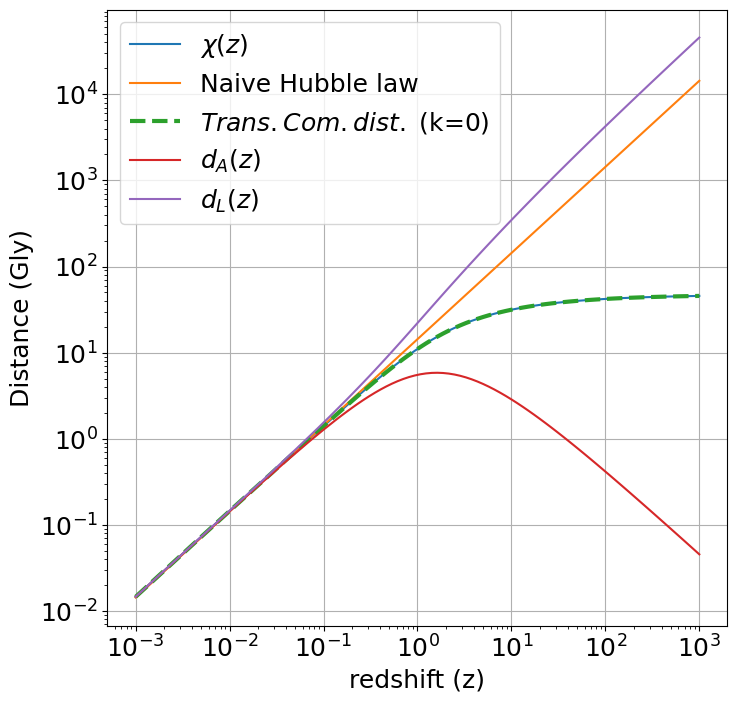

In [128]:
plt.figure(figsize=(8,8))
factMpc2Gly = 0.0032615 #Mpc -> Gly
plt.plot(z,factMpc2Gly * chi_z, label=r"$\chi(z)$")
plt.plot(z,factMpc2Gly * const.rh/cosmo_jax.h * z, label="Naive Hubble law")
plt.plot(z,factMpc2Gly * trans_com_z,ls="--",lw=3, label=rf"$Trans. Com. dist.$ (k={cosmo_jax.k})")
plt.plot(z,factMpc2Gly * ang_diam_z, label=r"$d_A(z)$")
plt.plot(z,factMpc2Gly * lum_z, label=r"$d_L(z)$")
plt.xlabel("redshift (z)")
plt.ylabel("Distance (Gly)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()

## gradient/vectorisation sur $\Omega_c$


In [131]:
omc=jnp.linspace(0.001,0.5,5) # series of values

In [132]:
def test(cosmo,z):
    return cosmo.Omega_c * z


the gradient is on the 1st test argument ie. cosmo_jax, of which we take only the component that Omega_c or Omega_), and then we vectorize on the 2nd argument here the redshift

In [134]:
vmap(grad(test), in_axes=(None,0))(cosmo_jax,jnp.array([0.01,0.1,1.0])).Omega_c    # trivialy is return Omega_c values

Array([0.01, 0.1 , 1.  ], dtype=float64, weak_type=True)

In [135]:
vmap(grad(test), in_axes=(None,0))(cosmo_jax,jnp.array([0.01,0.1,1.0])).Omega_b     # trivialy test does not depend on Omega_b

Array([0., 0., 0.], dtype=float64, weak_type=True)

In [136]:
vlum = vmap(luminosity_distance, in_axes=(Cosmology(0, None,None,None,None,None), None))
vang_diam = vmap(angular_diameter_distance, in_axes=(Cosmology(0, None,None,None,None,None), None))


In [139]:
cosmo_cs = Cosmology(omc,cosmo_jax.Omega_b,cosmo_jax.h,cosmo_jax.Omega_k,cosmo_jax.w0,cosmo_jax.wa)

In [141]:
cosmo_cs

 h:0.682 Omega_b:0.0485 Omega_c:[0.001   0.12575 0.2505  0.37525 0.5    ] Omega_k:0.0 w0:-1.0 wa:0.0

In [143]:
cosmo_cs.Omega_c

Array([0.001  , 0.12575, 0.2505 , 0.37525, 0.5    ], dtype=float64)

In [152]:
cosmo_cs.Omega_de


Array([0.9505 , 0.82575, 0.701  , 0.57625, 0.4515 ], dtype=float64)

In [145]:
data_lum=vlum(cosmo_cs,z2a(z))
data_lum /= cosmo_jax.h


In [146]:
data_ang_diam=vang_diam(cosmo_cs,z2a(z))
data_ang_diam /= cosmo_jax.h


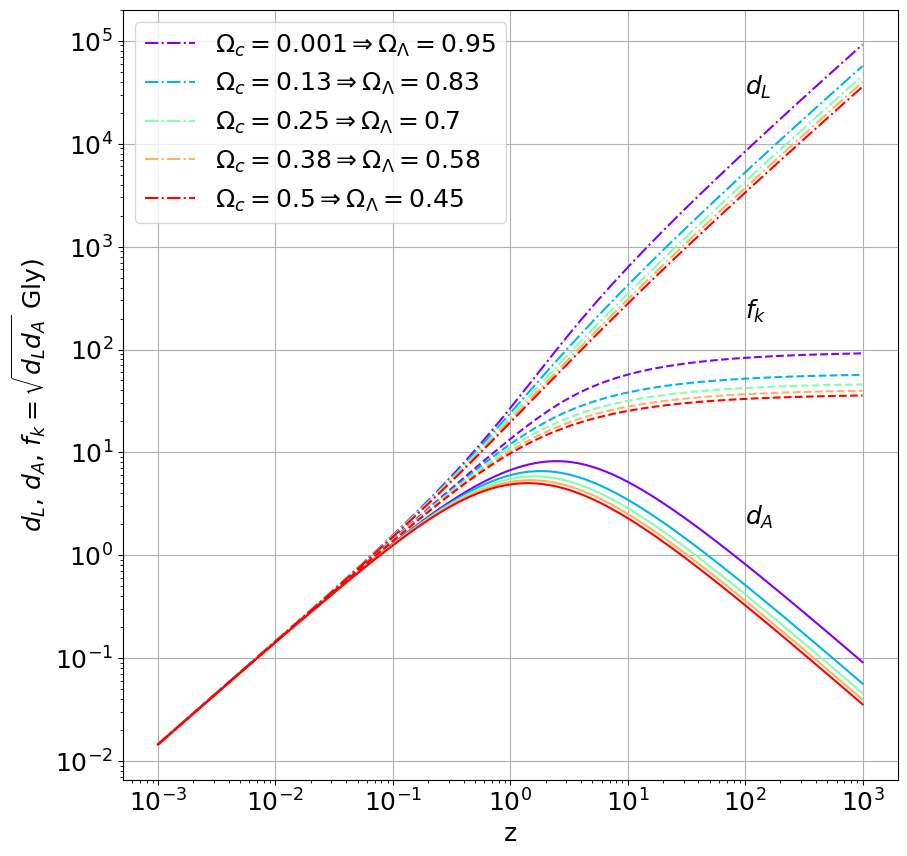

In [156]:
plt.figure(figsize=(10,10))
color = plt.cm.rainbow(np.linspace(0, 1, len(omc)))
for i,c in enumerate(omc):
    plt.plot(z, factMpc2Gly*data_lum[i,:], c=color[i],ls='-.',
             label=fr"$\Omega_c={c:.2}\Rightarrow \Omega_{{\Lambda}}={cosmo_cs.Omega_de[i]:.2}$")
    plt.plot(z, factMpc2Gly*data_ang_diam[i,:], c=color[i])
    plt.plot(z, factMpc2Gly*np.sqrt(data_lum[i,:]*data_ang_diam[i,:]), c=color[i],ls="--")
plt.legend()
plt.xlabel("z")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$d_L$, $d_A$, $f_k=\sqrt{d_L d_A}$ Gly)")
plt.text(100,3e4,r"$d_L$")
plt.text(100,2e2,r"$f_k$")
plt.text(100,2,r"$d_A$")
plt.grid();


# Takeaway message:

-    la différentiation d'algorithmes complexes est possible s'ils sont écrits en JAX
-    des études complexes de dépendance vis-à-vis de paramètrs sont possibles assez simplement
-    usage pratique des PyTree user
-    jax.scipy implémente des fonctionalités de Scipy
-    jax.lax.fori_loop, jax.lax.scan, jax.lax.switch
- vectorizaton vmap, compilation jit
-    le benchmarking

